In [25]:
%pip install pygeodyntools --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import pygeotools
import torch
import torch.nn as nn
import numpy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm


### Retrieving the data

In [27]:
model_path = "E:\INTERNSHIP\PINN\Code\geodynamo.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "geodynamo.hdf5"
pygeo.loadModel(
    modelName="geodynamo.hdf5",
    modelType="pygeodyn_hdf5",
    modelPath="geodynamo.hdf5"
)


pygeo.isLoaded("geodynamo.hdf5")  # Should return True

pygeotools was initialized with `verbose=True`.


True

In [28]:
if not pygeo.isGrid("3deg"):
    pygeo.addGrid("3deg", 3, 3)

pygeo.setGrid("3deg")

In [29]:
# Setting the grid
pygeo.setGrid("3deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

context_geo={
        "lmax": 18,
        "r": pygeo.constants["rCore"]


}

In [30]:
# Computing the MF and SV
MF = pygeo.addMeasure("geodynamo.hdf5", "MF", context)
SV = pygeo.addMeasure("geodynamo.hdf5", "SV", context)

13


In [31]:
U = pygeo.addMeasure("geodynamo.hdf5", "U", context_geo)

In [32]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

In [33]:
# Selecting the data
Br = MF[-1,...,0]
#Br = pygeo.selectFromMeasure("geodynamo.hdf5", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("geodynamo.hdf5", SV, options={"component": "r", "time": 2020})


In [34]:
u_theta_model = U[-1,...,1]
u_phi_model = U[-1,...,2]

#u_theta_model = pygeo.selectFromMeasure("geodynamo.hdf5", U, options={"component": "theta", "time": 2020})
#u_phi_model = pygeo.selectFromMeasure("geodynamo.hdf5", U, options={"component": "phi", "time": 2020})

In [35]:
dBrdth_full = numpy.gradient(Br,   thetas, axis=0)
dBrdph_full = numpy.gradient(Br,   phis,   axis=1)


Generating patches

In [36]:
def generate_patches(theta_size=60, phi_size=60, overlap=5, verbose=True):
    patches = []

    # Step size = patch size - overlap
    dtheta = theta_size - overlap
    dphi = phi_size - overlap

    # Build patch list
    for i1 in range(0, 180 - theta_size + 1, dtheta):   # colatitude 0° → 180°
        i2 = i1 + theta_size
        for j1 in range(0, 360 - phi_size + 1, dphi):   # longitude 0° → 360°
            j2 = j1 + phi_size
            patches.append((i1, i2, j1, j2))

    if verbose:
        print(f"Generated patches with grid size: {theta_size}° × {phi_size}° (overlap {overlap}°)")
        print(f"Total patches: {len(patches)}")

    return patches


In [37]:
# Change these anytime
theta_size = 60
phi_size = 60
overlap = 5

patches = generate_patches(theta_size, phi_size, overlap)

for i1, i2, j1, j2 in patches:
    print(f"Patch: colatitude {i1}-{i2}°, longitude {j1}-{j2}°")


Generated patches with grid size: 60° × 60° (overlap 5°)
Total patches: 18
Patch: colatitude 0-60°, longitude 0-60°
Patch: colatitude 0-60°, longitude 55-115°
Patch: colatitude 0-60°, longitude 110-170°
Patch: colatitude 0-60°, longitude 165-225°
Patch: colatitude 0-60°, longitude 220-280°
Patch: colatitude 0-60°, longitude 275-335°
Patch: colatitude 55-115°, longitude 0-60°
Patch: colatitude 55-115°, longitude 55-115°
Patch: colatitude 55-115°, longitude 110-170°
Patch: colatitude 55-115°, longitude 165-225°
Patch: colatitude 55-115°, longitude 220-280°
Patch: colatitude 55-115°, longitude 275-335°
Patch: colatitude 110-170°, longitude 0-60°
Patch: colatitude 110-170°, longitude 55-115°
Patch: colatitude 110-170°, longitude 110-170°
Patch: colatitude 110-170°, longitude 165-225°
Patch: colatitude 110-170°, longitude 220-280°
Patch: colatitude 110-170°, longitude 275-335°


In [38]:
# Loop over each patch
for patch_idx, (i1, i2, j1, j2) in enumerate(patches, start=1):

    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
        continue  # skip equator and near-pole patches

    if (i2 - i1) == 0 or (j2 - j1) == 0:
        print(f" Skipping empty patch: i1={i1}, i2={i2}, j1={j1}, j2={j2}")
        continue

    if i2 > Br.shape[0] or j2 > Br.shape[1]:
        print(f" Skipping out-of-bound patch: i2={i2}, j2={j2}, Br_all shape={Br.shape}")
        continue

    Br_patch_all = Br[i1:i2, j1:j2]  # shape: [ni, nj, 400]

    if Br_patch_all.shape[0] == 0 or Br_patch_all.shape[1] == 0:
        print(f"Empty patch shape: {Br_patch_all.shape} for i=({i1},{i2}) j=({j1},{j2})")
        continue

    # Mean and std across realizations
    Br_obs_patch = torch.tensor(Br_patch_all.reshape(-1, 1), dtype=torch.float32)

    # Flatten
    Br_obs = Br_obs_patch

    

 Skipping out-of-bound patch: i2=170, j2=60, Br_all shape=(60, 120)
 Skipping out-of-bound patch: i2=170, j2=115, Br_all shape=(60, 120)
 Skipping out-of-bound patch: i2=170, j2=170, Br_all shape=(60, 120)
 Skipping out-of-bound patch: i2=170, j2=225, Br_all shape=(60, 120)
 Skipping out-of-bound patch: i2=170, j2=280, Br_all shape=(60, 120)
 Skipping out-of-bound patch: i2=170, j2=335, Br_all shape=(60, 120)


### Defining the NN model

In [39]:
node_inputs = 2
node_outputs = 3
node_layer = 20
hidden_layers = 8

In [40]:

class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()

        layers = []

        layers.append(nn.Linear(node_inputs, node_layer))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(node_layer, node_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(node_layer, node_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [41]:
import math
import math
import torch.nn.functional as F


In [42]:
def gaussian_filter_2d_torch(input, sigma, truncate=4):
    
    """
    Applying a 2-d Gaussian filter on a map
        - (tensor) `input` the input tensor
        - (int) `sigma` the standard deviation for the Gaussian kernel
        - (int) `truncate` truncate the filter at this many standard deviation
    """
    
    if sigma == 0.0: return input
    # Computing the kernel size
    kernel_size = 2 * math.ceil(sigma * truncate) + 1

    # Creating the 1-d kernel
    x = torch.arange(kernel_size).float()  - (kernel_size - 1) / 2
    kernel_1d = torch.exp(-(x / sigma)**2 / 2)
    kernel_1d /= kernel_1d.sum()

    # Creating the 2-d kernel
    kernel_2d =  torch.outer(kernel_1d, kernel_1d)

    # Formatting the kernel for the conv2d layer (H, W) -> (B = 1, C = 1, H, W)
    kernel_2d = kernel_2d.unsqueeze(0).unsqueeze(0)

    # Applying the 2-d convolution
    output = F.conv2d(input.unsqueeze(0).unsqueeze(0), kernel_2d, padding="same")

    # Removing the batch (B) and channel (C) dimensions
    return output.squeeze(0).squeeze(0)

In [43]:
import numpy as np

def compute_synthetic_sv(U, Br, thetas, phis, r=3480.0, time_index=-1):
    if U.ndim == 4:
        u_theta = U[time_index, ..., 1]
        u_phi   = U[time_index, ..., 2]
    else:
        u_theta = U[..., 1]
        u_phi   = U[..., 2]

    if Br.ndim == 4:
        br = Br[time_index, ..., 0]
    elif Br.ndim == 3 and Br.shape[-1] >= 1:
        br = Br[..., 0]
    else:
        br = Br

    θ_grid, φ_grid = np.meshgrid(thetas, phis, indexing="ij")
    sinθ = np.clip(np.sin(θ_grid), 1e-12, None)
    cosθ = np.cos(θ_grid)

    if len(thetas) < 2 or len(phis) < 2:
        raise ValueError("Need at least two grid points in each dimension for np.gradient")

    dθ = np.gradient(thetas)[0]
    dφ = np.gradient(phis)[0]

    uθ_sinθ = u_theta * sinθ
    duθ_sinθ_dθ = np.gradient(uθ_sinθ, dθ, axis=0)
    duφ_dφ      = np.gradient(u_phi, dφ, axis=1)
    divh_uh     = (1.0 / (r * sinθ)) * (duθ_sinθ_dθ + duφ_dφ)

    dbr_dθ = np.gradient(br, dθ, axis=0)
    dbr_dφ = np.gradient(br, dφ, axis=1)
    gradθ_br = dbr_dθ / r
    gradφ_br = dbr_dφ / (r * sinθ)

    dbrdt = -(br * divh_uh + u_theta * gradθ_br + u_phi * gradφ_br)

    return dbrdt


smooth a 2D field (like Br) using a Gaussian filter so that you remove fine-scale noise and keep only the large-scale structure. to modify the L3 loss so that only large-scale features are being fitted.

In [ ]:
from dataclasses import dataclass
import torch

# Centralised configuration for the loss function
@dataclass
class LossParams:
    alpha: float = 0
    sigma: float = 0
    n1_scale: float = 0
    n2_sq: float = 0
    n3_sq: float = 0

def compute_loss(model, inputs, thetas_nn, phis_nn, dBrdt_nn, Br_obs, params: LossParams):
    """Compute individual loss terms and total loss."""
    r = torch.tensor(pygeo.constants["rCore"])

    # Predictions from the network
    u_pred = model(inputs)
    T, S, Br_nn = u_pred[:, 0:1], u_pred[:, 1:2], u_pred[:, 2:3]

    # Compute derivatives w.r.t. angles
    dBrdth_nn = torch.autograd.grad(Br_nn, thetas_nn, grad_outputs=torch.ones_like(Br_nn),
                                    create_graph=True, retain_graph=True)[0]
    dBrdph_nn = torch.autograd.grad(Br_nn, phis_nn, grad_outputs=torch.ones_like(Br_nn),
                                    create_graph=True, retain_graph=True)[0]

    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T),
                                 create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T),
                                 create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S),
                                 create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S),
                                 create_graph=True, retain_graph=True)[0]

    sin_th = torch.sin(thetas_nn)
    cos_th = torch.cos(thetas_nn)
    tan_th = torch.tan(thetas_nn)

    # Compute velocity components
    u_th = dT_dph / sin_th + dS_dth
    u_ph = -dT_dth + dS_dph / sin_th

    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn,
                                            grad_outputs=torch.ones_like(u_th_sin_th),
                                            create_graph=True, retain_graph=True)[0]
    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph),
                                     create_graph=True, retain_graph=True)[0]

    divH_uH = (1.0 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)
    gradH_Br_th = (1.0 / r) * dBrdth_nn
    gradH_Br_ph = (1.0 / (r * sin_th)) * dBrdph_nn

    # First loss term
    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph
    L1_loss = (L1 ** 2).mean()

    N1_sq_new = dBrdt_nn.pow(2).mean() / params.n1_scale

    # Second loss term
    L2 = cos_th * divH_uH - sin_th * u_th / r
    L2_loss = (L2 ** 2).mean()

    # Third loss term: smooth and compare to observations
    Br_filtered = Br_nn
    Br_residual = Br_filtered - Br_obs
    L3_loss = torch.mean(Br_residual ** 2)

    # Combine losses with normalisations
    L1_loss_final = L1_loss / N1_sq_new
    L2_loss_final = params.alpha * (L2_loss / params.n2_sq)
    L3_loss_final = L3_loss / params.n3_sq

    total_loss = L1_loss_final + L2_loss_final + L3_loss_final
    return (L1, total_loss,
            L1_loss_final, L2_loss_final, L3_loss_final,
            u_th, u_ph, Br_filtered, Br_nn)



params = LossParams(sigma=0, alpha=1, n1_scale=10.0, n2_sq=1e-4, n3_sq=2.5e9)


##Traning loop

In [45]:
# Training over all patches
num_realizations = 1  
epochs = 3000

patch_centers = []
loss_history  = []
L1_history    = []
L2_history    = []
L3_history   = []
Flow_complexity_history = []
Br_complexity_history = []

print(f"Number of times each patch will run: {num_realizations}")
print(f"Number of epochs: {epochs}")

# Filter out skipped patches first
valid_patches = [
    p for p in patches
    if not (p[0] < 10 or p[1] > 170 or (p[0] <= 90 <= p[1]))
]

# Take the first valid patch
test_patches = valid_patches[0:1]

print(test_patches)
print(f"Training on {len(test_patches)} patches")
print(f"Number of patches: {len(patches)} but we will consider : {len(test_patches)}")

# Degree grid for mapping patch degrees to index positions
deg_thetas = np.linspace(0, 180, len(thetas))  # degrees from 0° to 180°
deg_phis   = np.linspace(0, 360, len(phis))    # degrees from 0° to 360°

for patch_idx, (i1, i2, j1, j2) in enumerate(test_patches, start=1):
    # Skip poles and equator patches if needed
    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
        continue

    print(f"Processing patch {patch_idx} (skipped earlier poles/equator)")

    # Convert patch degrees → array indices
    i1_idx = np.searchsorted(deg_thetas, i1)
    i2_idx = np.searchsorted(deg_thetas, i2)
    j1_idx = np.searchsorted(deg_phis, j1)
    j2_idx = np.searchsorted(deg_phis, j2)

    # 1) slice the data & precomputed gradients
    Br_patch     = Br[i1_idx:i2_idx, j1_idx:j2_idx, ...]
    Br_patch_all = Br[i1_idx:i2_idx, j1_idx:j2_idx]  # shape: [ni, nj, ...]
    Br_obs_patch = torch.tensor(Br_patch_all.reshape(-1, 1), dtype=torch.float32)
    Br_obs = Br_obs_patch

    dBrdth_patch = dBrdth_full[i1_idx:i2_idx, j1_idx:j2_idx, ...]
    dBrdph_patch = dBrdph_full[i1_idx:i2_idx, j1_idx:j2_idx, ...]
    u_theta_model_patch = u_theta_model[i1_idx:i2_idx, j1_idx:j2_idx]
    u_phi_model_patch   = u_phi_model[i1_idx:i2_idx, j1_idx:j2_idx]

    # 2) slice the angles & mesh
    thetas_bis = thetas[i1_idx:i2_idx]
    phis_bis   = phis[j1_idx:j2_idx]
    thg, phg   = np.meshgrid(thetas_bis, phis_bis, indexing="ij")
    th_flat    = thg.ravel()[:, None]
    ph_flat    = phg.ravel()[:, None]

    # 3) build torch tensors
    thetas_nn = torch.tensor(th_flat, dtype=torch.float32, requires_grad=True)
    phis_nn   = torch.tensor(ph_flat, dtype=torch.float32, requires_grad=True)

    inputs = torch.cat([thetas_nn, phis_nn], dim=1).contiguous()
    

    for run in range(num_realizations):
        print(f"\n=== Training run {run+1}/{num_realizations} on patch {patch_idx} ===")

        # instantiate model
        model = CoreFlowPINN()

        # set up optimizer + scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        from torch.optim.lr_scheduler import CosineAnnealingLR
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

        # ensure grads on inputs
        thetas_nn.requires_grad_(True)
        phis_nn.requires_grad_(True)

        for epoch in range(1, epochs+1):
            if epoch == 1:
                with torch.no_grad():
                    last_layer = model.net[-1]
                    last_layer.weight[0] += torch.tensor(
                        np.random.normal(1, 15, last_layer.weight[0].shape), dtype=torch.float32
                    )
                    last_layer.weight[1] += torch.tensor(
                        np.random.normal(1, 15, last_layer.weight[1].shape), dtype=torch.float32
                    )
                    last_layer.weight[2] += torch.tensor(
                        np.random.normal(1e5, 1e6, last_layer.weight[2].shape), dtype=torch.float32
                    )

            optimizer.zero_grad()

            # Slice U and MF for this patch (safe for both time and no-time dims)
            if U.ndim == 4:
                U_patch = U[-1, i1_idx:i2_idx, j1_idx:j2_idx, :]
            else:
                U_patch = U[i1_idx:i2_idx, j1_idx:j2_idx, :]

            if MF.ndim == 4:
                MF_patch = MF[-1, i1_idx:i2_idx, j1_idx:j2_idx, :]
            else:
                MF_patch = MF[i1_idx:i2_idx, j1_idx:j2_idx, :]

            # Compute synthetic SV for this patch
            dBrdt_patch_syn = compute_synthetic_sv(
                U_patch,
                MF_patch,
                thetas_bis,
                phis_bis,
                r=pygeo.constants["rCore"]
            )
           

            # Convert to torch tensor
            dBrdt_nn = torch.tensor(
                dBrdt_patch_syn.flatten()[:, None],
                dtype=torch.float32
            )

            # Compute loss
            L1, total_loss, L1_loss_final, L2_loss_final, L3_loss_final, \
            u_th, u_ph, Br_filtered, Br_nn = compute_loss(
                model, inputs, thetas_nn, phis_nn, dBrdt_nn, Br_obs, params
            )

            # Backprop
            Loss_main = total_loss
            Loss_main.backward()
            optimizer.step()
            scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d} | "
                      f"L1 {L1_loss_final:.2e} | "
                      f"L2 {L2_loss_final:.2e} | "
                      f"L3 {L3_loss_final:.2e}")

            loss_history.append(Loss_main.item())
            L1_history.append(L1_loss_final.item())
            L2_history.append(L2_loss_final.item())
            L3_history.append(L3_loss_final.item())

    patch_centers.append(((i1 + i2)//2, (j1 + j2)//2))

print("Done computing for all patches.")




Number of times each patch will run: 1
Number of epochs: 3000
[(110, 170, 0, 60)]
Training on 1 patches
Number of patches: 18 but we will consider : 1
Processing patch 1 (skipped earlier poles/equator)

=== Training run 1/1 on patch 1 ===
Epoch  100 | L1 1.00e+01 | L2 4.87e-04 | L3 9.21e+00
Epoch  200 | L1 1.00e+01 | L2 6.32e-04 | L3 8.74e+00
Epoch  300 | L1 9.98e+00 | L2 3.20e-03 | L3 8.26e+00
Epoch  400 | L1 1.00e+01 | L2 7.75e-03 | L3 6.12e+00
Epoch  500 | L1 9.48e+00 | L2 6.09e-02 | L3 5.05e+00
Epoch  600 | L1 9.17e+00 | L2 8.14e-02 | L3 4.65e+00
Epoch  700 | L1 8.45e+00 | L2 7.23e-02 | L3 4.46e+00
Epoch  800 | L1 7.57e+00 | L2 1.86e-01 | L3 4.41e+00
Epoch  900 | L1 7.28e+00 | L2 1.86e-01 | L3 4.43e+00
Epoch 1000 | L1 7.17e+00 | L2 1.50e-01 | L3 4.42e+00
Epoch 1100 | L1 7.11e+00 | L2 1.18e-01 | L3 4.41e+00
Epoch 1200 | L1 7.06e+00 | L2 9.91e-02 | L3 4.42e+00
Epoch 1300 | L1 6.99e+00 | L2 8.81e-02 | L3 4.44e+00
Epoch 1400 | L1 6.89e+00 | L2 8.40e-02 | L3 4.46e+00
Epoch 1500 | L1 6.7

In [46]:
import os
import json
import torch
from datetime import datetime



# 1) Define your constant base directory once
BASE_OUT_DIR = r"E:\INTERNSHIP\PINN\Code\training_outputs"
run_name = f"SV_Sigma={params.sigma}__{epochs}_{theta_size}x{phi_size}_3degree"
out_dir   = os.path.join(BASE_OUT_DIR, run_name)
os.makedirs(out_dir, exist_ok=True)
print("Saving everything to:", out_dir)

# 2) Build your checkpoint dict
checkpoint = {
    "params": {
        "model_name":    model_name,
        "node_inputs":   node_inputs,
        "node_outputs":  node_outputs,
        "node_layer":    node_layer,
        "hidden_layers": hidden_layers,
        "learning_rate": 0.001,
        "epochs":        epochs,
        "simga":        params.sigma,
        "alpha":        params.alpha,
        "patch":         (i1, i2, j1, j2),
        "theta_size":    theta_size,
        "phi_size":      phi_size,

    },
    "loss_history":         loss_history,
    "model_state_dict":     model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "final_epoch":          epoch,
}

# 3) Save the checkpoint into run_dir

save_path    = os.path.join(out_dir, "params_only_checkpoint.pth")
torch.save(checkpoint, save_path)
print(f"Saved checkpoint to {save_path}")

model.eval()
with torch.enable_grad():  # needed because compute_loss uses autograd.grad
            L1, total_loss, L1_loss_final, L2_loss_final, L3_loss_final, u_th, u_ph, Br_filtered, Br_nn = \
            compute_loss(model, inputs, thetas_nn, phis_nn, dBrdt_nn, Br_obs, params)
    
mae       = L1.abs().mean().item()
rmse      = torch.sqrt((L1**2).mean()).item()
obs_mean  = dBrdt_nn.abs().mean().item()
rel_err   = mae / obs_mean



metrics = {
    "rmse":       rmse,
    "mae":        mae,
    "rel_err":    rel_err,
    #"complexity": comp2.item(),
    "region":     f"{(i1+i2)//2}° colatitude",
    **checkpoint["params"]
}
metrics_path = os.path.join(out_dir, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f" Wrote metrics to {metrics_path}")

Saving everything to: E:\INTERNSHIP\PINN\Code\training_outputs\SV_Sigma=0__3000_60x60_3degree
Saved checkpoint to E:\INTERNSHIP\PINN\Code\training_outputs\SV_Sigma=0__3000_60x60_3degree\params_only_checkpoint.pth
 Wrote metrics to E:\INTERNSHIP\PINN\Code\training_outputs\SV_Sigma=0__3000_60x60_3degree\metrics.json


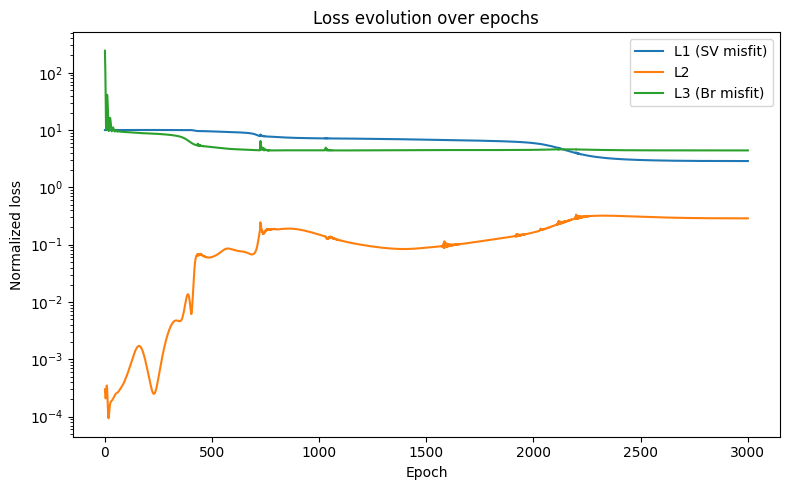

In [47]:
import matplotlib.pyplot as plt

epochs = len(L1_history)
x = range(1, epochs+1)

plt.figure(figsize=(8,5))
plt.plot(x, L1_history, label='L1 (SV misfit)')
plt.plot(x, L2_history, label='L2')
plt.plot(x, L3_history, label='L3 (Br misfit)')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Normalized loss')
plt.title('Loss evolution over epochs')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "Losses.png"))
plt.show()

In [48]:


def relative_error_comparison(rel_err):

    threshold = 0.10  # 10% relative error
    if rel_err > threshold:
        print(f"Patch at {patch_centers}°: relative error {rel_err:.2%} exceeds 10% threshold ")
    else:
        print(f"Patch at {patch_centers}°: relative error {rel_err:.2%} is within acceptable bounds.")


compare = relative_error_comparison(rel_err)


print("-------------------------------------------------------------")
print(f"  MAE (L1)            = {mae:.3e}")
print(f"  |dBr/dt|_mean (obs) = {obs_mean:.3e}")
print(f"  Relative error      = {rel_err:.2f}")





Patch at [(140, 30)]°: relative error 63.58% exceeds 10% threshold 
-------------------------------------------------------------
  MAE (L1)            = 1.860e+03
  |dBr/dt|_mean (obs) = 2.926e+03
  Relative error      = 0.64


### Predictions

In [49]:

L1, total_loss, L1_loss_final, L2_loss_final, L3_loss_final, u_th, u_ph, Br_filtered, Br_nn = \
            compute_loss(model, inputs, thetas_nn, phis_nn, dBrdt_nn, Br_obs, params)
def plot_sv_patch(Br_nn,
                  Br_filtered = None,
                  dBrdt_nn=None,        
                  L1=None,
                  u_ph=None,
                  u_th=None,
                  thetas_bis=None,
                  phis_bis=None,
                  patch_id=None,
                  a=None,
                  title=None,
                  units=None,
                  u_theta_model_patch = None,
                  u_phi_model_patch = None):
    
    
    # Determine data
    if a is not None:
        data = a
    elif dBrdt_nn is not None:
        data = dBrdt_nn
    else:
        data = Br_nn



    # Choose coloring data
    data = a if a is not None else Br_nn
    if hasattr(data, 'detach'):
        data = data.detach().numpy()

    # Build lat/lon grids
    theta_grid, phi_grid = np.meshgrid(thetas_bis, phis_bis, indexing='ij')
    lat_grid = 90 - np.rad2deg(theta_grid)
    lon_grid = np.rad2deg(phi_grid)

    # Create figure + map
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    
        # center zero in the colormap
    vmax = np.nanmax(np.abs(data))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    sc = ax.scatter(lon_grid, lat_grid,
                    c=data,
                    cmap='seismic',   # red–white–blue
                    norm=norm,       # ensures 0→white
                    s=20,
                    transform=ccrs.PlateCarree())


    # Colorbar
    cb = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.05)
    cb_label = units if units else r'$\partial B_r / \partial t$ (SV)'
    cb.set_label(cb_label, fontsize=12)

 
    cb.set_ticks([-vmax, 0, vmax])


    # Title selection: use custom title if provided
    if title is not None:
        ax.set_title(title)
    else:
        default_title = f"SV Patch {patch_id}" if patch_id is not None else "SV Patch"
        ax.set_title(default_title)

    plt.tight_layout()
    return fig, ax




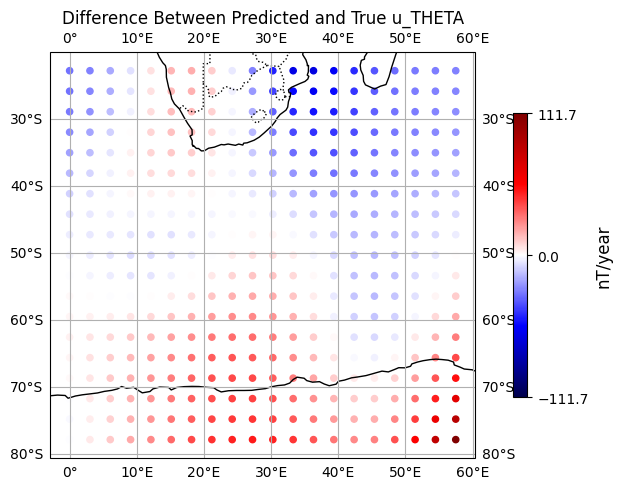

In [50]:
fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a = u_theta_model_patch - u_th.detach().numpy().squeeze().reshape(19, 20),
    title="Difference Between Predicted and True u_THETA",
    units="nT/year",
    u_theta_model_patch = u_theta_model_patch,
    u_phi_model_patch = u_phi_model_patch
)

plt.savefig(os.path.join(out_dir, "u_theta_model_patch-u_th"))
plt.show()


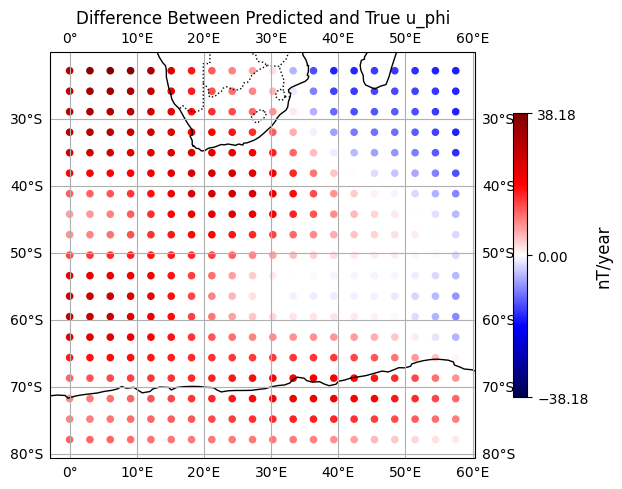

In [51]:
fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a = u_phi_model_patch - u_ph.detach().numpy().squeeze().reshape(19, 20),
    title="Difference Between Predicted and True u_phi",
    units="nT/year",
    u_theta_model_patch = u_theta_model_patch,
    u_phi_model_patch = u_phi_model_patch
)

plt.savefig(os.path.join(out_dir, "u_phi_model_patch - u_ph"))
plt.show()


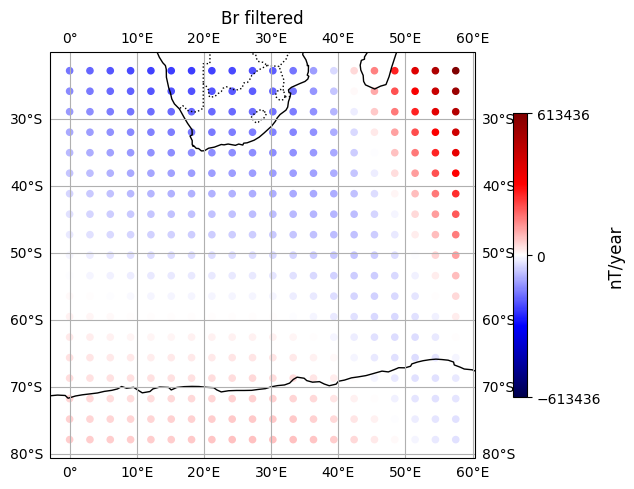

In [52]:
fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=Br_filtered.detach().numpy(),
    title="Br filtered",
    units="nT/year",
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch
)

plt.savefig(os.path.join(out_dir, "Br filtered"))
plt.show()





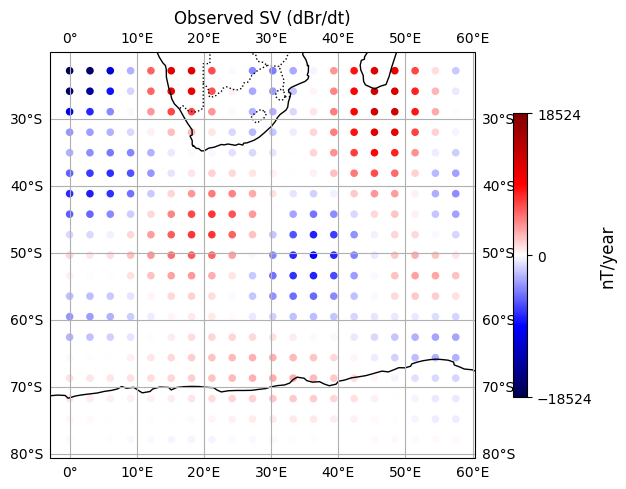

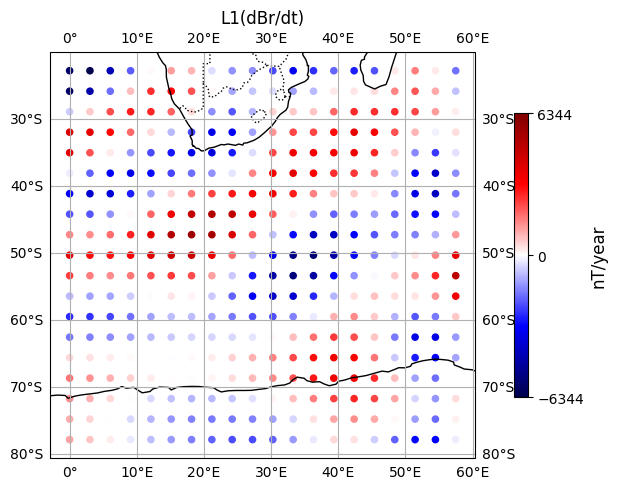

In [58]:
fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=dBrdt_nn.detach().numpy(),
    title="Observed SV (dBr/dt)",
    units="nT/year",
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch
)

safe_filename = "Observed SV.png"
plt.savefig(os.path.join(out_dir, safe_filename))
plt.show()


fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=L1.detach().numpy(),
    title="L1(dBr/dt)",
    units="nT/year",
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch
)

safe_filename = "L1.png"
plt.savefig(os.path.join(out_dir, safe_filename))
plt.show()




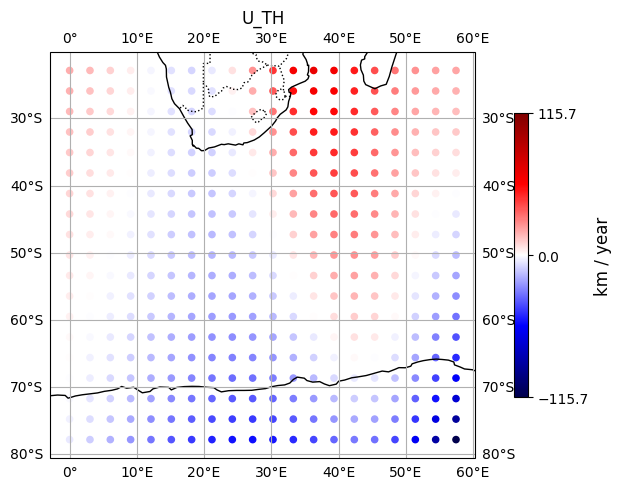

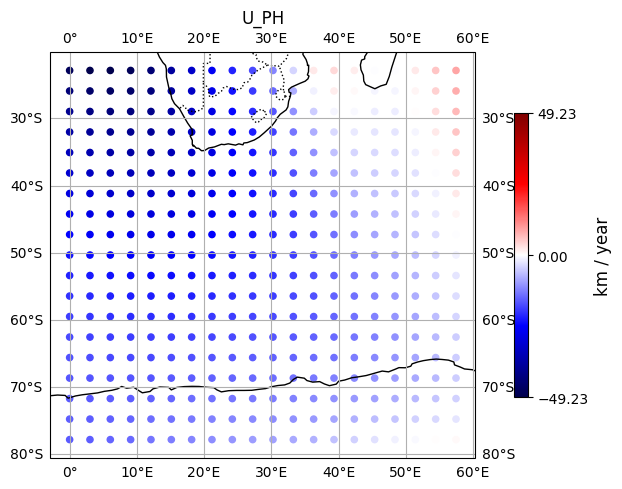

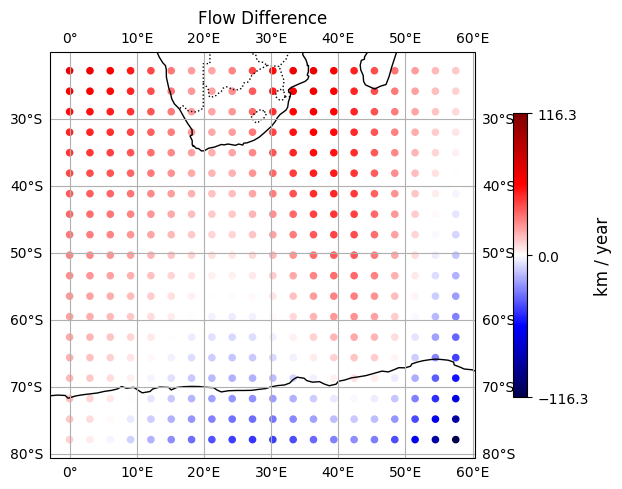

In [54]:




fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_th.detach().numpy(),
    title="U_TH",
    units="km / year",  
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch
)

plt.savefig(os.path.join(out_dir, "U_TH"))
plt.show()

fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_ph.detach().numpy(),
    title="U_PH",
    units="km / year"  ,
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch  )   

plt.savefig(os.path.join(out_dir, "U_PH"))
plt.show()


fig, ax = plot_sv_patch(
    dBrdt_nn,
    Br_nn,
    Br_filtered,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=(u_th-u_ph).detach().numpy(),
    title="Flow Difference",
    units="km / year",  
    u_theta_model_patch = u_theta_model_patch ,
    u_phi_model_patch = u_phi_model_patch    
)

plt.savefig(os.path.join(out_dir, "Flow Difference"))
plt.show()






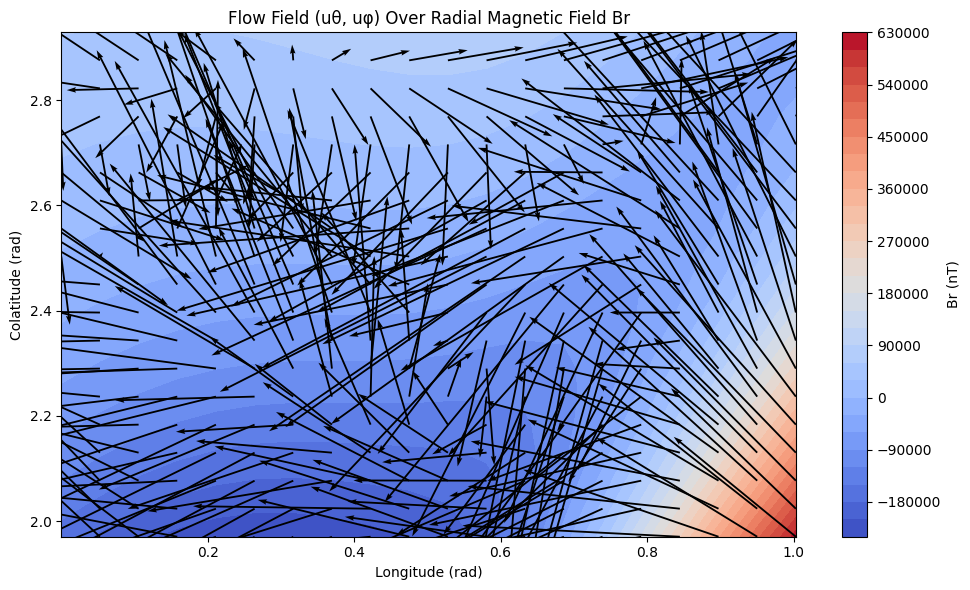

In [55]:
Br = Br_nn.detach().numpy().reshape(19, 20)

# u_theta_model_patch and u_phi_model_patch are already NumPy arrays
u_theta_np = u_theta_model_patch
u_phi_np   = u_phi_model_patch

theta_grid, phi_grid = np.meshgrid(thetas_bis, phis_bis, indexing="ij")

plt.figure(figsize=(10, 6))
plt.contourf(phi_grid, theta_grid, Br, levels=30, cmap="coolwarm")
plt.colorbar(label="Br (nT)")

plt.quiver(phi_grid, theta_grid,
           u_phi_np, -u_theta_np,
           color='k', scale=50, width=0.0025)

plt.xlabel("Longitude (rad)")
plt.ylabel("Colatitude (rad)")
plt.title("Flow Field (uθ, uφ) Over Radial Magnetic Field Br")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "Quiver plot"))
plt.show()



In [56]:
import os
import json
import pandas as pd

metrics_path = os.path.join(out_dir, "metrics.json")

if os.path.exists(metrics_path):
    with open(metrics_path) as f:
        m = json.load(f)
        rmse_percent = round(m["rel_err"] * 100, 2)
        patch = m["patch"]
        epochs = m["epochs"]

    df = pd.DataFrame([{
        "patch":        patch,
        "rmse_percent": rmse_percent,
        "epochs":       epochs
    }])

    csv_path = os.path.join(out_dir, "model_summary.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved summary to {csv_path}")
else:
    print("metrics.json not found in this run folder.")


Saved summary to E:\INTERNSHIP\PINN\Code\training_outputs\SV_Sigma=0__3000_60x60_3degree\model_summary.csv
